In [1]:
import pandas as pd
import re

In [2]:
all_pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_pull_request.parquet")
pr_commits_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_commits.parquet")

C:\Users\gnand\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
pr_commit_details_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_commit_details.parquet")
related_issue_df = pd.read_parquet("hf://datasets/hao-li/AIDev/related_issue.parquet")
issue_df = pd.read_parquet("hf://datasets/hao-li/AIDev/issue.parquet")

Function below is used to scan the given text parameter (string) to see if the text contains any context related to code testing contributions (using regex to match the test pattern).  
  
**return value** - true if match found, false otherwise

In [3]:
test_pattern = r"((integration|integrated|unit|system|functional|ui|(user([_\-\s]*)interface)|(end|e)([_\-\s]*)(to|2)([_\-\s]*)(end|e))([_\-\s]*)test)|pytest"

def scan_text_for_test_contributions(text) :
    if text is None :
        return False
    text = str(text).lower()
    return re.search(test_pattern, text) is not None

Below we get the dataframes for all PR's related to test contributions based on regex matchings, and all PR commits related to test contributions who's Pull requests weren't directly identifiable for test contributions (these 2 dfs are disjoint on pr_id)

In [4]:
code_test_PRs = all_pr_df[all_pr_df['title'].apply(scan_text_for_test_contributions) | all_pr_df['body'].apply(scan_text_for_test_contributions)]

code_test_PR_commits = pr_commits_df[pr_commits_df['message'].apply(scan_text_for_test_contributions)]
code_test_PR_commits = code_test_PR_commits[~code_test_PR_commits['pr_id'].isin(code_test_PRs['id'])]

Below we move both the title and body columns of text into a new text column, and delete the body and title columns for the code test PRs

In [5]:
code_test_PRs = code_test_PRs[['id', 'title', 'body']]
code_test_PRs['text'] = code_test_PRs['title']+"\n\n"+code_test_PRs['body']
code_test_PRs = code_test_PRs.drop(['title', 'body'], axis =1)
#code_test_PRs[code_test_PRs['id'].isna()]

Below we do the similar to the code test pr commits df, so that it also has same columns as the code test PRs df. We then concatenate the 2 dfs to get all PRs with test contributions:

In [6]:
code_test_PR_commits = code_test_PR_commits[['pr_id', 'message']]
code_test_PR_commits = code_test_PR_commits.groupby('pr_id').agg(lambda x: '\n\n'.join(x)).reset_index()
code_test_PR_commits = code_test_PR_commits.rename(columns = {'pr_id': 'id', 'message': 'text'})

In [7]:
code_test_PRs = pd.concat([code_test_PRs, code_test_PR_commits])

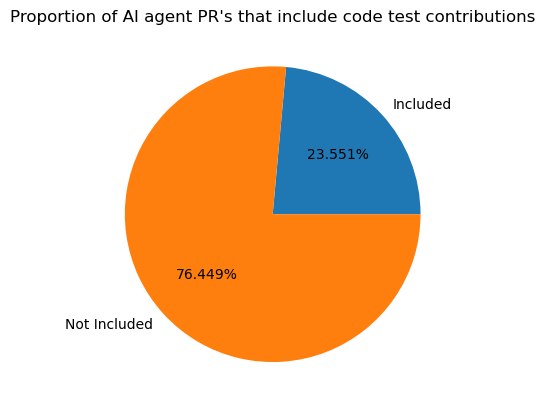

In [8]:
import matplotlib.pyplot as plt

labels = "Included", "Not Included"
sizes = [code_test_PRs.shape[0], all_pr_df.shape[0]-code_test_PRs.shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.3f%%')
plt.title("Proportion of AI agent PR's that include code test contributions")
plt.show()

Here we set a dictionary which maps each individual test type regex to a test contribution category.

In [9]:
test_category_counts = {"Integration Tests":0, "Unit Tests":0, "System Tests":0, "End-to-End Tests":0,
                        "UI Tests (Automated)":0}

regex_to_categories = {"(integration([_\-\s]*)test)|(integrated([_\-\s]*)test)": "Integration Tests", "unit([_\-\s]*)test": "Unit Tests", 
"system([_\-\s]*)test": "System Tests", "(((end|e)([_\-\s]*)(to|2)([_\-\s]*)(end|e))|functional)([_\-\s]*)test": 
                      "End-to-End Tests", "(ui|(user([_\-\s]*)interface))([_\-\s]*)test": "UI Tests (Automated)"}

<>:4: SyntaxWarning: invalid escape sequence '\-'
<>:4: SyntaxWarning: invalid escape sequence '\-'
<>:5: SyntaxWarning: invalid escape sequence '\-'
<>:5: SyntaxWarning: invalid escape sequence '\-'
<>:6: SyntaxWarning: invalid escape sequence '\-'
<>:4: SyntaxWarning: invalid escape sequence '\-'
<>:4: SyntaxWarning: invalid escape sequence '\-'
<>:5: SyntaxWarning: invalid escape sequence '\-'
<>:5: SyntaxWarning: invalid escape sequence '\-'
<>:6: SyntaxWarning: invalid escape sequence '\-'
C:\Users\gnand\AppData\Local\Temp\ipykernel_4140\2089256776.py:4: SyntaxWarning: invalid escape sequence '\-'
  regex_to_categories = {"(integration([_\-\s]*)test)|(integrated([_\-\s]*)test)": "Integration Tests", "unit([_\-\s]*)test": "Unit Tests",
C:\Users\gnand\AppData\Local\Temp\ipykernel_4140\2089256776.py:4: SyntaxWarning: invalid escape sequence '\-'
  regex_to_categories = {"(integration([_\-\s]*)test)|(integrated([_\-\s]*)test)": "Integration Tests", "unit([_\-\s]*)test": "Unit Tests",


Below we check each test type categories regex for matches on all the test contribution PR's to count the amount of PR's that contribute each type of test.

In [10]:
for pattern in regex_to_categories.keys():
    test_pattern = rf"{pattern}"
    key = regex_to_categories[pattern]
    matching_prs = code_test_PRs[code_test_PRs['text'].apply(scan_text_for_test_contributions)]
    test_category_counts[key] = test_category_counts[key]+int(matching_prs.shape[0])
    
    

In [11]:
print(test_category_counts)

{'Integration Tests': 10587, 'Unit Tests': 37265, 'System Tests': 447, 'End-to-End Tests': 3945, 'UI Tests (Automated)': 1349}


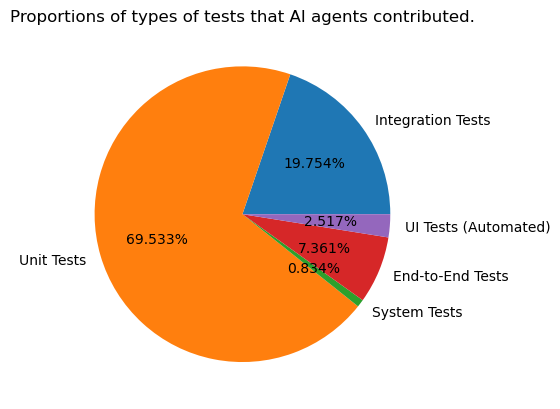

In [12]:
import matplotlib.pyplot as plt

labels = list(test_category_counts.keys())
sizes = list(test_category_counts.values())

plt.pie(sizes, labels=labels, autopct='%1.3f%%')
plt.title("Proportions of types of tests that AI agents contributed.")
plt.show()